原文链接: 

切换目录

In [2]:
import os
while os.getcwd().split('\\')[-1] != "Data_Analyst_FJNU":
    os.chdir('..')
print(os.getcwd())

e:\Desktop\学业\第五学期课业\数据分析\Data_Analyst_FJNU


导包

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

读取数据

In [4]:
stock_data = pd.read_csv('./Data/history_A_stock_k_data/sh.600010.csv')
stock_data.head()

,date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST
0,2001-03-09,sh.600010,6.80,6.80,6.36,6.40,5.18,184839687,1.199614e+09,3,52.811339,1,23.552130,0
1,2001-03-12,sh.600010,6.38,6.43,6.31,6.37,6.40,21713538,1.382885e+08,3,6.203868,1,-0.468753,0
2,2001-03-13,sh.600010,6.40,6.56,6.40,6.51,6.37,27308195,1.777207e+08,3,7.802341,1,2.197808,0
3,2001-03-14,sh.600010,6.51,6.56,6.50,6.53,6.51,12919592,8.432932e+07,3,3.691312,1,0.307219,0
4,2001-03-15,sh.600010,6.53,6.65,6.48,6.59,6.53,23845329,1.564755e+08,3,6.812951,1,0.918835,0


处理数据
只留下感兴趣的参数
把日期设为索引

In [5]:
# propertylist = ['open','high','low','close','preclose','volume']
propertylist = ['open','high','low','close','preclose']
stock_data = stock_data [['date']+propertylist]
stock_data['date'] = pd.to_datetime(stock_data['date'])
stock_data.set_index('date',inplace=True)
print(stock_data.head())
print(stock_data.tail())

            open  high   low  close  preclose
date                                         
2001-03-09  6.80  6.80  6.36   6.40      5.18
2001-03-12  6.38  6.43  6.31   6.37      6.40
2001-03-13  6.40  6.56  6.40   6.51      6.37
2001-03-14  6.51  6.56  6.50   6.53      6.51
2001-03-15  6.53  6.65  6.48   6.59      6.53
            open  high   low  close  preclose
date                                         
2023-12-20  1.42  1.43  1.39   1.39      1.42
2023-12-21  1.38  1.42  1.37   1.41      1.39
2023-12-22  1.41  1.43  1.39   1.42      1.41
2023-12-25  1.42  1.44  1.41   1.43      1.42
2023-12-26  1.43  1.43  1.40   1.41      1.43


绘制图像

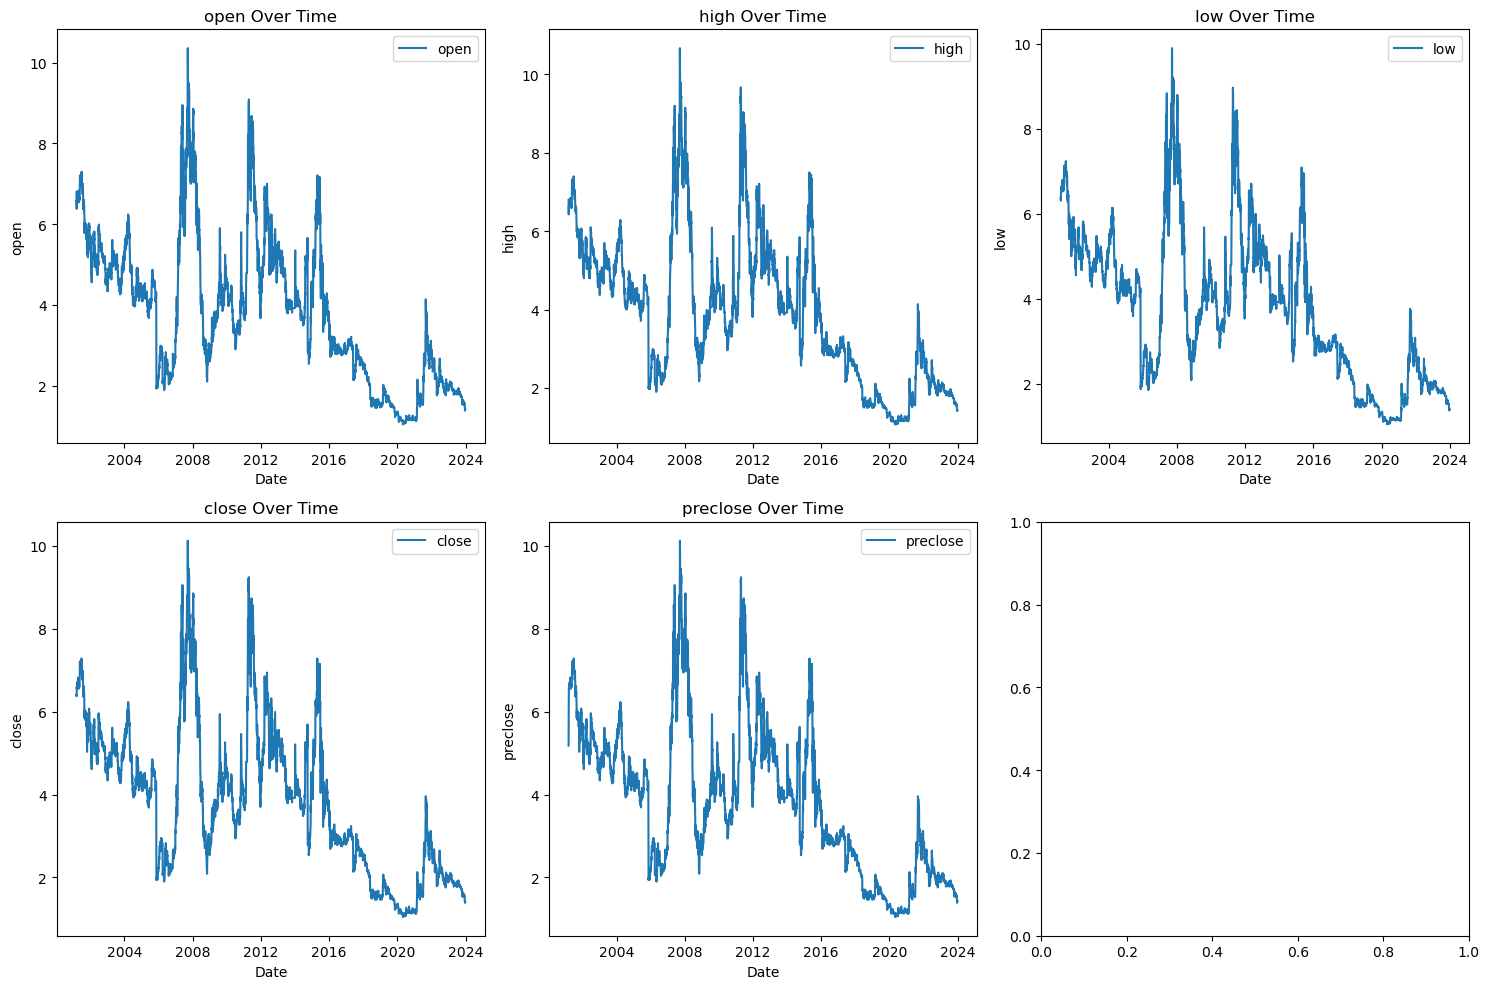

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, name in enumerate(propertylist):
    axes[i].plot(stock_data[name], label=name)
    axes[i].set_title(f'{name} Over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(name)
    axes[i].legend()
plt.tight_layout()
plt.show()

数据归一化处理

In [7]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(stock_data)

创建训练集和测试集

In [8]:

step = 50
training_size = round(len(scaled_data ) * 0.90)
scaled_train_data = scaled_data[:training_size]
scaled_test_data  = scaled_data[training_size:]
def create_sequence(dataset, size):
    sequences = []
    labels = []
    start_idx = 0
    for stop_idx in range(size,len(dataset)):
        sequences.append(dataset[start_idx:stop_idx])
        labels.append(dataset[stop_idx])
        start_idx += 1
    return np.array(sequences), np.array(labels)
scaled_train_seq, scaled_train_label = create_sequence(scaled_train_data,step)
scaled_test_seq, scaled_test_label = create_sequence(scaled_test_data,step)
print("训练数据形状：", scaled_train_seq.shape)
print("训练标签形状：", scaled_train_label.shape)
print("测试数据形状：", scaled_test_seq.shape)
print("测试标签形状：", scaled_test_label.shape)


训练数据形状： (4932, 50, 5)
训练标签形状： (4932, 5)
测试数据形状： (504, 50, 5)
测试标签形状： (504, 5)


建立模型

In [9]:
# 建立新模型
dimension = 64
model = Sequential()

model.add(LSTM(units=dimension, return_sequences=True, input_shape=(scaled_train_seq.shape[1], scaled_train_seq.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(units=dimension, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=dimension))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(propertylist)))

# 使用Adam优化器
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001), metrics=['mean_absolute_error'])
model.summary()

# 添加早停法
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 训练模型
history = model.fit(scaled_train_seq, scaled_train_label, epochs=20, validation_data=(scaled_test_seq, scaled_test_label), callbacks=[early_stopping], verbose=1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 64)            17920     
                                                                 
 dropout (Dropout)           (None, 50, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 50, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4

155/155 [==============================] - 14s 49ms/step - loss: 0.0068 - mean_absolute_error: 0.0485 - val_loss: 1.2357e-04 - val_mean_absolute_error: 0.0078
Epoch 2/20
155/155 [==============================] - 6s 39ms/step - loss: 0.0020 - mean_absolute_error: 0.0294 - val_loss: 6.9809e-04 - val_mean_absolute_error: 0.0244
Epoch 3/20
155/155 [==============================] - 6s 41ms/step - loss: 0.0017 - mean_absolute_error: 0.0269 - val_loss: 1.1480e-04 - val_mean_absolute_error: 0.0081
Epoch 4/20
155/155 [==============================] - 6s 41ms/step - loss: 0.0014 - mean_absolute_error: 0.0250 - val_loss: 3.4742e-04 - val_mean_absolute_error: 0.0163
Epoch 5/20
155/155 [==============================] - 7s 43ms/step - loss: 0.0011 - mean_absolute_error: 0.0219 - val_loss: 1.0688e-04 - val_mean_absolute_error: 0.0075
Epoch 6/20
155/155 [==============================] - 6s 41ms/step - loss: 0.0011 - mean_absolute_error: 0.0214 - val_loss: 7.1429e-05 - val_mean_absolute_error: 0.0

In [10]:
# model = Sequential()

# model.add(LSTM(units=dimension, return_sequences=True, input_shape=(scaled_train_seq.shape[1], scaled_train_seq.shape[2])))
# model.add(Dropout(0.2))
# model.add(LSTM(units=dimension, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=dimension))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(len(propertylist)))


# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
# model.summary()
# history = model.fit(scaled_train_seq, scaled_train_label, epochs=20, validation_data=(scaled_test_seq, scaled_test_label), verbose=1)

训练模型

训练历史

平均绝对误差 (MAE):

定义：对预测误差的绝对值进行平均。
公式：$MAE= \frac  1 n ∑ _{i=1} ^n∣y_i − \hat{y}_i∣$
优劣：MAE越小越好。

 1/16 [>.............................] - ETA: 0s - loss: 2.7524e-04 - mean_absolute_error: 0.0150

16/16 [==============================] - 0s 22ms/step - loss: 2.0140e-04 - mean_absolute_error: 0.0133
Test Loss: 0.00020140041306149215, Test Mean Absolute Error: 0.013293572701513767


C:\Users\Shelt\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


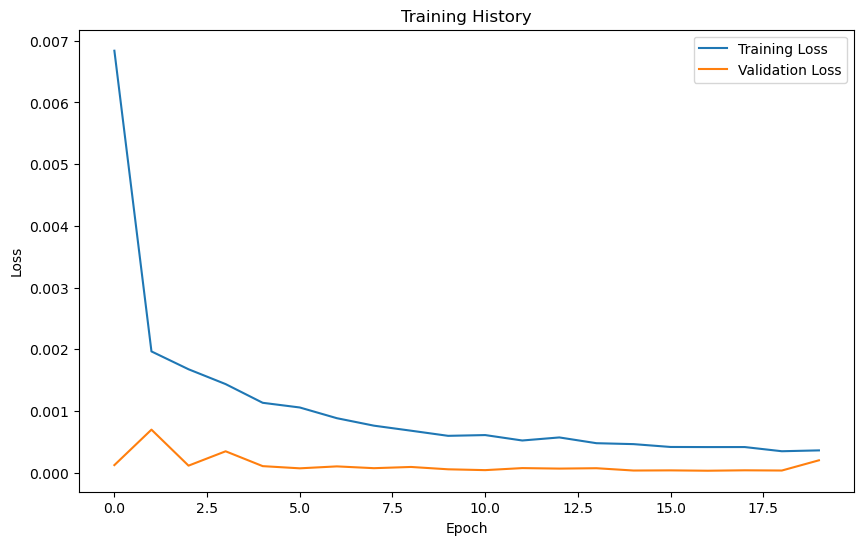

In [11]:
loss, mean_absolute_error = model.evaluate(scaled_test_seq,scaled_test_label)
print(f'Test Loss: {loss}, Test Mean Absolute Error: {mean_absolute_error}')
model.save('./Data/model/test.h5')
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [12]:
# 测试集预测并逆变换
scaled_test_predicted = model.predict(scaled_test_seq)
test_predicted = scaler.inverse_transform(scaled_test_predicted)
test_predicted_df = pd.DataFrame(test_predicted, columns=propertylist)
test_predicted_df['date'] = stock_data.index[-len(scaled_test_seq):]
test_predicted_df.set_index('date',inplace=True)
# test_predicted_df = test_predicted_df.round(2)
print(stock_data.tail())
print(test_predicted_df.tail())

16/16 [==============================] - 1s 15ms/step
            open  high   low  close  preclose
date                                         
2023-12-20  1.42  1.43  1.39   1.39      1.42
2023-12-21  1.38  1.42  1.37   1.41      1.39
2023-12-22  1.41  1.43  1.39   1.42      1.41
2023-12-25  1.42  1.44  1.41   1.43      1.42
2023-12-26  1.43  1.43  1.40   1.41      1.43
                open      high       low     close  preclose
date                                                        
2023-12-20  1.510938  1.559241  1.494511  1.514502  1.517919
2023-12-21  1.493357  1.539386  1.475345  1.495396  1.499284
2023-12-22  1.482050  1.527474  1.463722  1.483652  1.487314
2023-12-25  1.481660  1.526253  1.463467  1.483374  1.486073
2023-12-26  1.490739  1.535214  1.473398  1.493293  1.494486


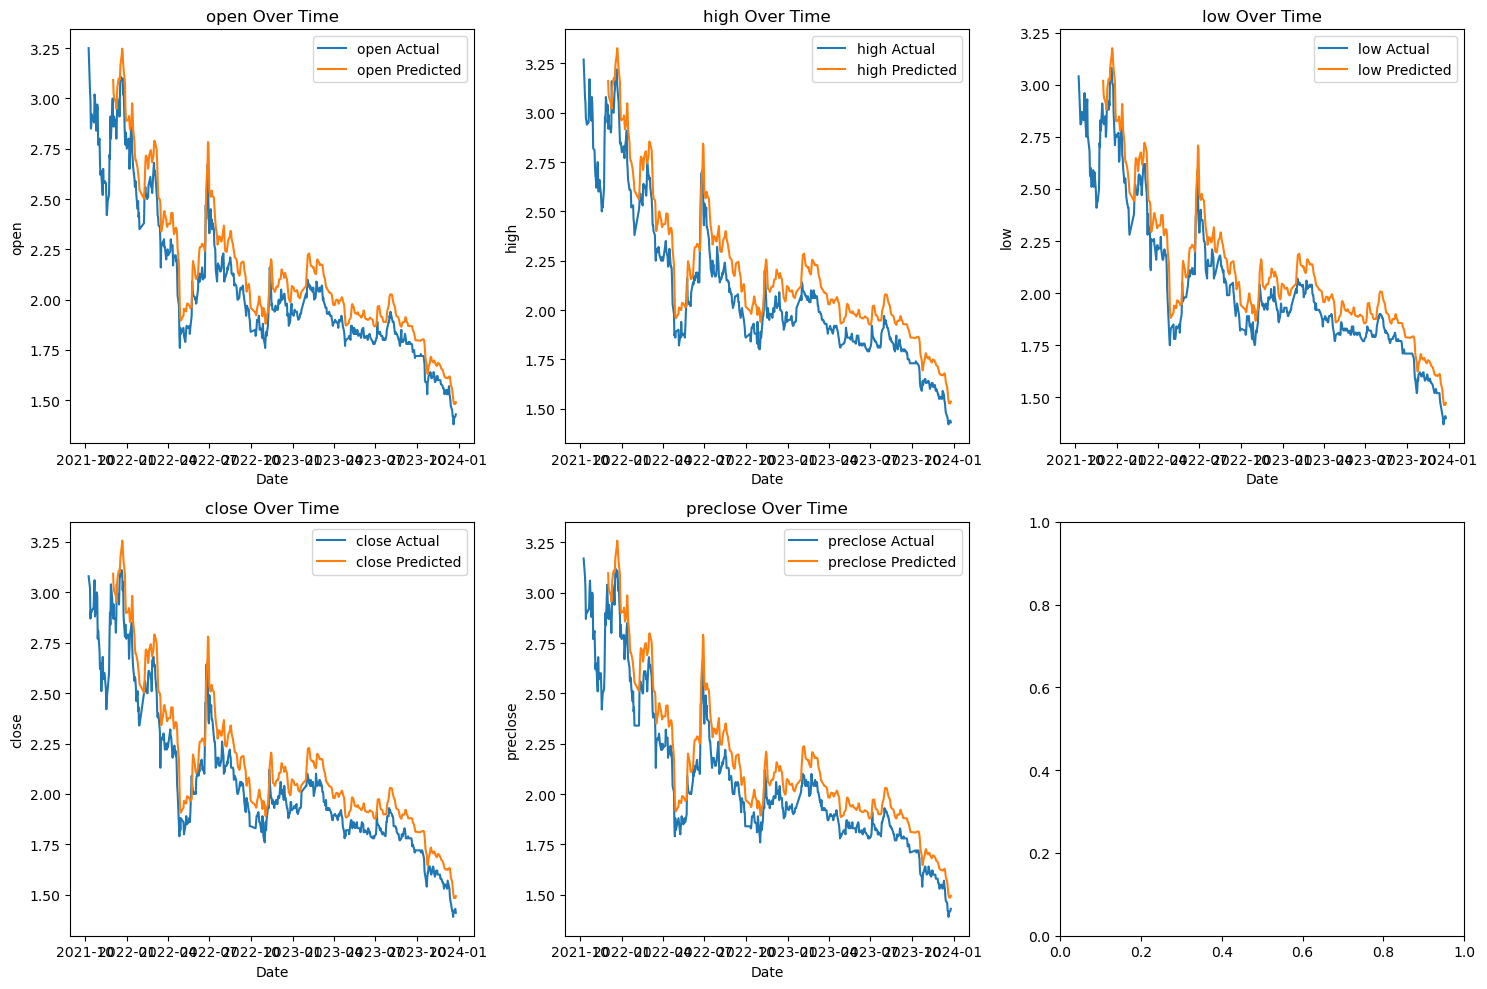

In [13]:
start_date = '2021-10-01'
end_date = '2024-01-10'
stock_data_tail = stock_data[start_date:end_date]
test_predicted_df_tail = test_predicted_df[start_date:end_date]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, name in enumerate(propertylist):
    axes[i].plot(stock_data_tail[name], label=f'{name} Actual')
    axes[i].plot(test_predicted_df_tail[name], label=f'{name} Predicted')
    axes[i].set_title(f'{name} Over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(name)
    axes[i].legend()
plt.tight_layout()
plt.show()


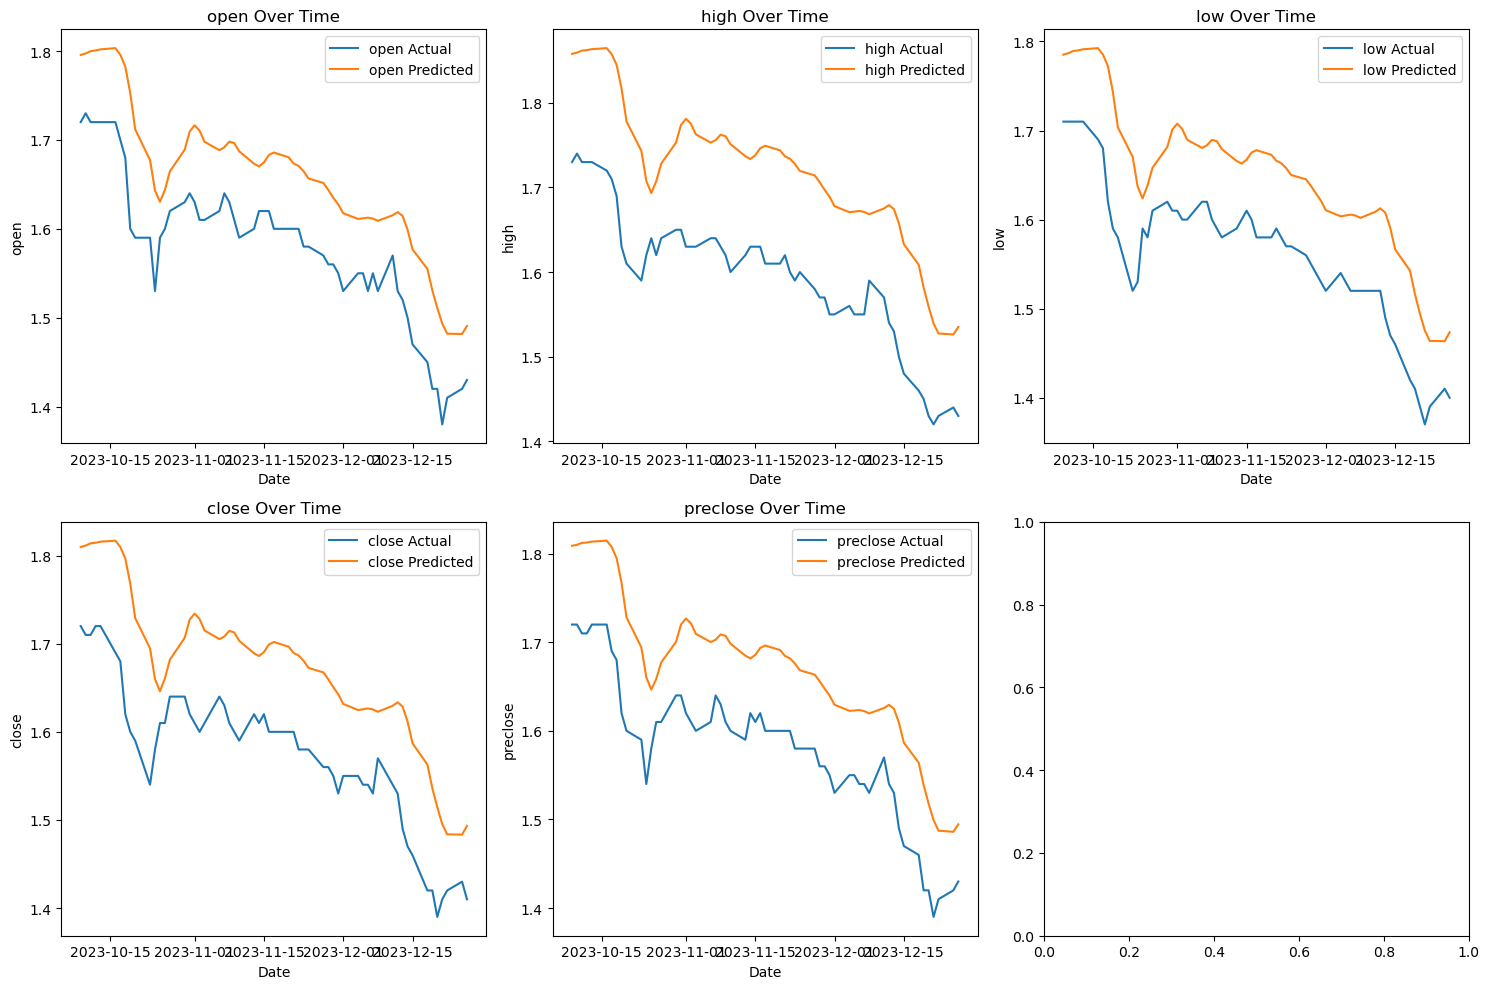

In [14]:
start_date = '2023-10-01'
end_date = '2024-01-10'
stock_data_tail = stock_data[start_date:end_date]
test_predicted_df_tail = test_predicted_df[start_date:end_date]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, name in enumerate(propertylist):
    axes[i].plot(stock_data_tail[name], label=f'{name} Actual')
    axes[i].plot(test_predicted_df_tail[name], label=f'{name} Predicted')
    axes[i].set_title(f'{name} Over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(name)
    axes[i].legend()
plt.tight_layout()
plt.show()

In [15]:
final_X = np.array([scaled_data[-50:]])
scaled_nextday_predicted = model.predict(final_X)
predicted_result = scaler.inverse_transform(scaled_nextday_predicted)
predicted_result_df = pd.DataFrame(predicted_result, columns=propertylist)
print(predicted_result_df)

1/1 [==============================] - 0s 22ms/step
       open      high       low     close  preclose
0  1.497244  1.542583  1.480905  1.500678  1.500896


In [16]:
over_X = np.array([np.concatenate((scaled_data[-49:],scaled_nextday_predicted), axis=0)])
scaled_overday_predicted = model.predict(over_X)
over_result = scaler.inverse_transform(scaled_overday_predicted)
print(pd.DataFrame(over_result, columns=propertylist))


1/1 [==============================] - 0s 30ms/step
      open      high       low     close  preclose
0  1.52731  1.576185  1.514344  1.533897  1.531104
